In [2]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm, tqdm_notebook
import pandas as pd
import numpy as np
import gzip
import json
import math
from datetime import datetime
import seaborn as sns
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display
%matplotlib inline
import pickle

import sys
sys.path.append('..')
from helper.rl_framework import *
from helper.orderbook_container import OrderbookContainer
from helper.manage_orderbooks import *
from helper.orderbook_trader import *
# from helper.RL_Agent import RLAgent
# from agents.NN_Agent import RLAgent_NN
from agents.BatchTree_Agent import RLAgent_BatchTree
from Runs.train_BatchTree import train_RL, trainer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
V=100
T=4
P=15

filename_train = '/home/axel/data/small/obs_2016-11_USDT_BTC_maxVol100.dict'

actions = list(np.linspace(-0.4, 1.0, num=15))
actions = range(-4,10)
print("Actions: ", ", ".join(["{:1.0f}".format(a) for a in actions]))

episodes_train = OrderbookEpisodesGenerator(filename=filename_train, episode_length=T*P)
print("Length of episodes_train: {}".format(len(episodes_train)))

Actions:  -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
Length of episodes_train: 541


### Settings

In [4]:
# cached_episodes = list(episodes_train[:20])
# pickle.dump( cached_episodes, open( "cached_episodes.p", "wb" ) )
data = pickle.load( open( "cached_windows/tradingwindows_1611_USTD_BTC_20.p", "rb" ) )
data[0][0].timestamp

'2016-11-08T10:00'

In [44]:
def load_and_preprocess_historyfiles(files):
    hist = pd.DataFrame()
    for file in histfiles:
        data = pd.read_csv(file, index_col=0)
        hist = pd.concat([hist, data])
    hist.set_index(keys=pd.to_datetime(hist.index), inplace=True)

    # remove dublicates and unneeded columns
    hist = hist[~hist.index.duplicated(keep='first')]
    hist.drop(["id", 'isFrozen'], axis=1, inplace=True)

    # fill gaps with last observation
    idx = pd.date_range(hist.index[0], hist.index[-1], freq="1min")
    hist = hist.sort_index().reindex(index=idx.sort_values(), method='ffill')
    
    # add more features
    hist['spread'] = hist.lowestAsk - hist.highestBid

    for lookahead in [15, 30, 45]:
        hist["future{}".format(lookahead)] = (hist['last'].shift(-lookahead) / hist['last']) - 1.

    return hist

histfiles = [
    "../../../../data/history/history_2016-11_USDT_BTC.csv",
    "../../../../data/history/history_2017-02_USDT_BTC.csv",
]

hist = load_and_preprocess_historyfiles(files=histfiles)
hist['future15_disc'] = pd.cut(hist.future15, bins=[-np.inf, -0.005, -0.001, 0.001, 0.005, np.inf], labels=False)
hist['future30_disc'] = pd.cut(hist.future30, bins=[-np.inf, -0.005, -0.001, 0.001, 0.005, np.inf], labels=False)
hist['future45_disc'] = pd.cut(hist.future45, bins=[-np.inf, -0.005, -0.001, 0.001, 0.005, np.inf], labels=False)
display(hist.iloc[1021:1025,:])

,baseVolume,high24hr,highestBid,last,low24hr,lowestAsk,percentChange,quoteVolume,spread,future15,future30,future45,future15_disc,future30_disc,future45_disc
2016-11-09 03:01:00,417050.045093,716.0,709.740242,709.740241,702.680396,711.419498,0.004009,586.622061,1.679256,0.002366,0.004593,0.013399,3.0,3.0,4.0
2016-11-09 03:02:00,417128.134302,716.0,709.768994,711.419498,702.680396,711.419498,0.006251,586.731342,1.650504,0.002019,0.003802,0.008926,3.0,3.0,4.0
2016-11-09 03:03:00,417086.272705,716.0,709.723616,711.419498,702.680396,711.419498,0.006251,586.672174,1.695882,0.002019,0.003802,0.010514,3.0,3.0,4.0
2016-11-09 03:04:00,417050.431869,716.0,710.000001,710.000000,702.680396,711.419498,0.003144,586.621473,1.419497,0.003122,0.005845,0.013099,3.0,4.0,4.0


In [45]:
# add features to orderbooks
for window in tqdm_notebook(data):
    for ob_idx, ob in enumerate(window):
        ob.features = {}
        ob.norm_factor = 1
        
        ob.features = {'spread': ob.asks.index[0]-ob.bids.index[0]}
        
        ts = pd.to_datetime(ob.timestamp)        
        ts_prev = pd.to_datetime(ob.timestamp) - pd.Timedelta('60Min')

        market_features = hist.loc[ts_prev:ts, :]
        
        for lookahead in [15,30,45]:
            ob.features["future{}".format(lookahead)] = market_features['future{}'.format(lookahead)][-1]

The installed widget Javascript is the wrong version.


RL-Type: <class 'agents.BatchTree_Agent.RLAgent_BatchTree'>


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


0: exploration = 1.0
1: exploration = 0.9659363289248455
2: exploration = 0.9330329915368074
3: exploration = 0.9012504626108302
4: exploration = 0.8705505632961241
5: exploration = 0.8408964152537146
6: exploration = 0.8122523963562355
7: exploration = 0.7845840978967507
8: exploration = 0.7578582832551991
9: exploration = 0.7320428479728127
10: exploration = 0.7071067811865475
11: exploration = 0.6830201283771977
12: exploration = 0.6597539553864472
13: exploration = 0.637280313659631
14: exploration = 0.6155722066724582
15: exploration = 0.6
16: exploration = 0.6
17: exploration = 0.6
18: exploration = 0.6
19: exploration = 0.6
20: exploration = 0.6
21: exploration = 0.6
22: exploration = 0.6
23: exploration = 0.6
24: exploration = 0.6
25: exploration = 0.6
26: exploration = 0.6
27: exploration = 0.6
28: exploration = 0.6
29: exploration = 0.6
30: exploration = 0.6
31: exploration = 0.6
32: exploration = 0.6
33: exploration = 0.6
34: exploration = 0.6
35: exploration = 0.6
36: explo

The installed widget Javascript is the wrong version.


state_dim:  2 ['volume', 'time']
n 0
Score: 0.988118552109
Feature importances: [ 0.63765047  0.29772406  0.06462547]
n 1
Score: 0.976733984537
Feature importances: [ 0.74669371  0.22734234  0.02596395]
n 2
Score: 0.98592882922
Feature importances: [ 0.85751288  0.13111668  0.01137044]
n 3
Score: 0.986498318045
Feature importances: [ 0.9108257   0.07202692  0.01714738]
n 4
Score: 0.984833530248
Feature importances: [ 0.91379068  0.07045073  0.01575859]
n 5
Score: 0.988368891929
Feature importances: [ 0.91233816  0.06887858  0.01878326]
n 6
Score: 0.98712855272
Feature importances: [ 0.92366744  0.06016538  0.01616717]
n 7
Score: 0.986674732292
Feature importances: [ 0.90891963  0.07523691  0.01584346]
brain.samples.shape (115, 10)


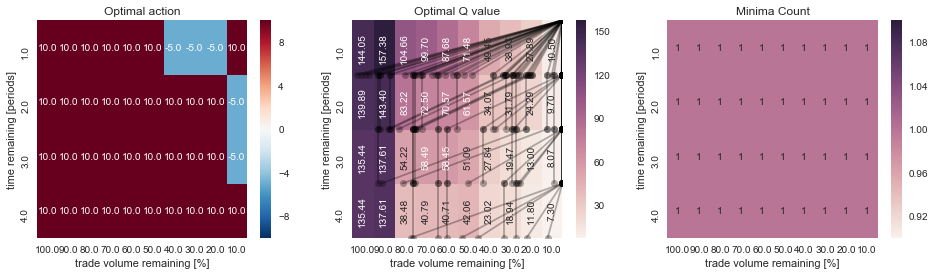

In [89]:
V=100
T=4
P=15

random.seed(13)
np.random.seed(13)
# plot_episode(episodes_train[1], volume=100)
data[0][0].timestamp
agent = trainer(orderbooks=data[17:18], V=V, T=T, actions=[-5, 10],
                lim_stepsize=0.1, limit_base='incStepUnits',
                period_length=P, epochs=50, random_start=True,
                state_variables=['volume', 'time'])
agent.heatmap_Q(show_traces=True, which_min='first', show_minima_count=True)
#agent.heatmap_Q(show_traces=True, which_min='last', show_minima_count=True)

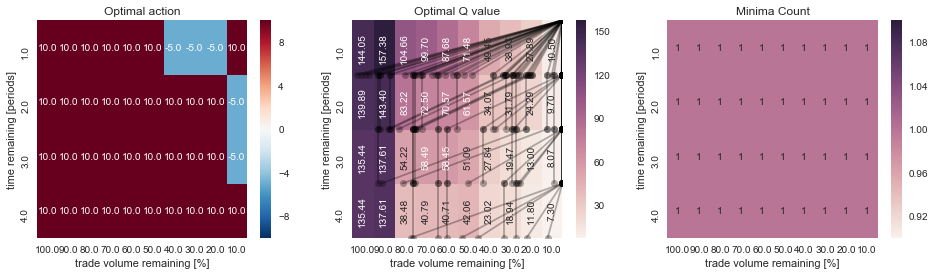

In [90]:
agent.heatmap_Q(show_traces=True, which_min='last', show_minima_count=True)

In [ ]:
for n in range(1,11):
    print("n={}".format(n))
    agent.fitted_Q_iteration_tree(n)
    if n > 5:
        agent.heatmap_Q(show_traces=False, vol_intervals=10, which_min='first', show_minima_count=True)

limits [717.68533463778181]
2016-11-09 04:01:00 2016-11-09 04:00:00 0 days 00:01:00


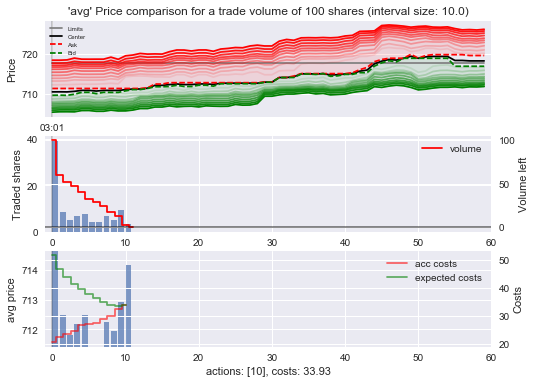

In [95]:
# plot_episode(data[0], actions=[-1, 5, 6, np.nan])
# plot_episode(data[1], actions=[-1, 5, 6, np.nan])
# plot_episode(data[1], actions=[2])
plot_episode(data[17], actions=[10], intervals=4)

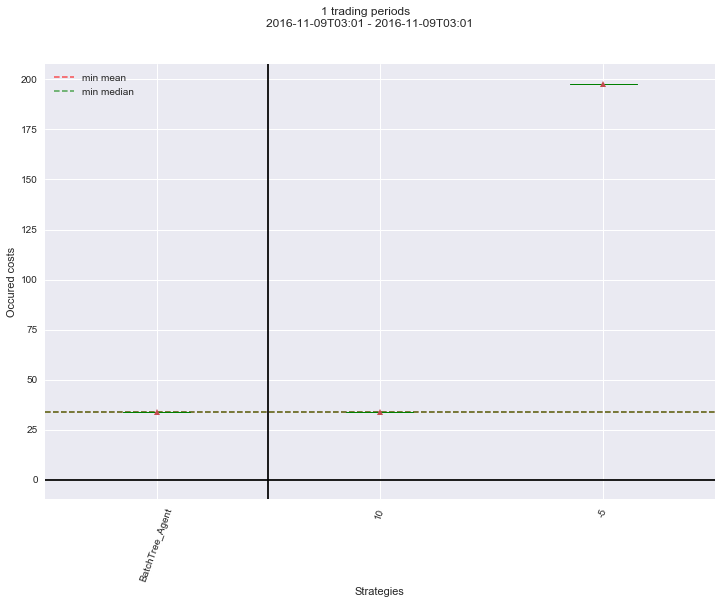

,BatchTree_Agent,10,-5
count,1.000000,1.000000,1.000000
mean,33.932666,33.932666,197.595276
std,NaN,NaN,NaN
min,33.932666,33.932666,197.595276
25%,33.932666,33.932666,197.595276
50%,33.932666,33.932666,197.595276
75%,33.932666,33.932666,197.595276
max,33.932666,33.932666,197.595276
rel_mean,1.000000,1.000000,5.823158
rel_median,1.000000,1.000000,5.823158


,BatchTree_Agent,10,-5
2016-11-09T03:01,33.932666,33.932666,197.595276


BatchTree_Agent     33.932666
10                  33.932666
-5                 197.595276
dtype: float64

In [94]:
costs = None
costs = agent.evaluate(
    testdata=data[17:18],
    evaluate_actions=[10, -5],
    costs=costs,
    verbose=True,
    show_plot=True)
display(costs)
display(costs.mean())

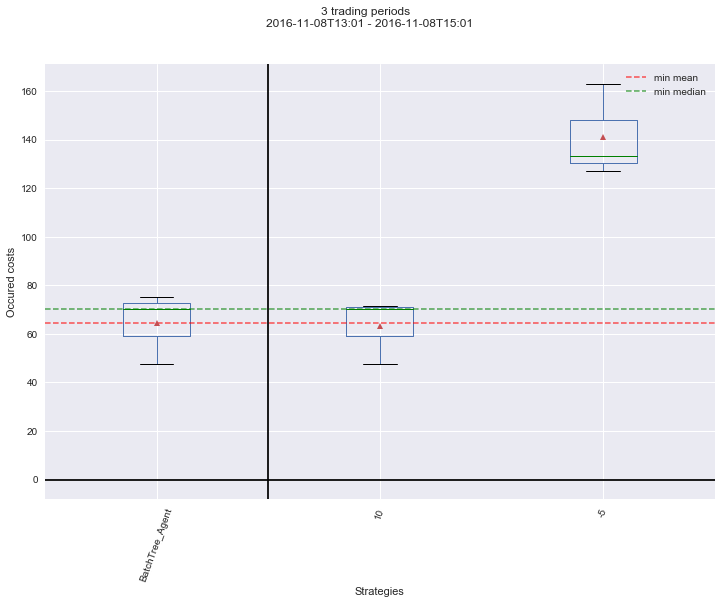

,BatchTree_Agent,10,-5
count,3.000000,3.000000,3.000000
mean,64.340038,63.183218,141.042267
std,14.746491,13.562163,19.072574
min,47.542888,47.542888,127.116675
25%,58.931330,58.931330,130.173016
50%,70.319772,70.319772,133.229358
75%,72.738613,71.003382,148.005063
max,75.157455,71.686993,162.780769
rel_mean,1.000000,0.982020,2.192138
rel_median,1.000000,1.000000,1.894622


,BatchTree_Agent,10,-5
2016-11-08T13:01,47.542888,47.542888,133.229358
2016-11-08T14:01,75.157455,71.686993,127.116675
2016-11-08T15:01,70.319772,70.319772,162.780769


BatchTree_Agent     64.340038
10                  63.183218
-5                 141.042267
dtype: float64

In [93]:
costs = None
costs = agent.evaluate(
    testdata=data[3:6],
    evaluate_actions=[10, -5],
    costs=costs,
    verbose=True,
    show_plot=True)
display(costs)
display(costs.mean())